In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# These are the models I use and how I get them: 
# https://waps.cfa.harvard.edu/MIST/interp_tracks.html
# For metallicities: 
# LMC-like: log10(0.006/0.0142) = -0.37
# SMC-like: log10(0.002/0.0142) = -0.85

# If you're doing photometry and need to convert from Vega to AB you can use these zeropoints
vega_ab_table = pd.read_csv('https://waps.cfa.harvard.edu/MIST/BC_tables/zeropoints.txt',delimiter='\s+')

# If you're loading in evolutionary models
your_directory = 'MIST/LMC/MIST/'
evol_files = glob.glob(f'{your_directory}*.track.*')

# If you're loading in photometry
your_directory = 'MIST/LMC/UBVI/'
phot_files = glob.glob(f'{your_directory}*.cmd')

# How to read in files
def Open_File(file_name):
    # Get the column names
    row = open(file_name, 'r').readlines()
    # It's the last comment in the file so get all the comments
    comments = [x for x in row if '#' in x  ]
    # Split the last row into individual keys, exclude the '#'
    columns = comments[-1].split()[1:]
    # Strip any blank spaces
    columns = [x.strip(' ') for x in columns]
    # Read in as pandas dataframe
    df = pd.read_csv(file_name, comment='#',names = columns,delimiter='\s+')
    return df

# Let's open one of the files:
df = Open_File(evol_files[-1])

# Show the first few rows to check that everything looks okay
df.head()


,star_age,star_mass,star_mdot,he_core_mass,c_core_mass,o_core_mass,log_L,log_L_div_Ledd,log_LH,log_LHe,...,delta_Pg,nu_max,acoustic_cutoff,max_conv_vel_div_csound,max_gradT_div_grada,gradT_excess_alpha,min_Pgas_div_P,max_L_rad_div_Ledd,e_thermal,phase
0,161.730423,12.399991,-4.807994e-08,0.0,0.0,0.0,3.904930,-3.223639,-6.428720,-99.0,...,0.0,1.622054,14.921548,0.643909,8.921419,0.0,0.914135,0.114222,3.671864e+48,-1.0
1,168.354098,12.399991,-4.750040e-08,0.0,0.0,0.0,3.903847,-3.214499,-6.394550,-99.0,...,0.0,1.635192,15.041488,1.092270,8.920115,0.0,0.914135,0.114220,3.687707e+48,-1.0
2,175.250518,12.399990,-4.708834e-08,0.0,0.0,0.0,3.901485,-3.212341,-6.359438,-99.0,...,0.0,1.649167,15.169982,0.889222,8.915576,0.0,0.914136,0.114219,3.704065e+48,-1.0
3,182.417937,12.399990,-4.654064e-08,0.0,0.0,0.0,3.898915,-3.211194,-6.323357,-99.0,...,0.0,1.663705,15.303782,0.698865,8.910375,0.0,0.914138,0.114176,3.720967e+48,-1.0
4,189.862988,12.399990,-4.596626e-08,0.0,0.0,0.0,3.896540,-3.207931,-6.286299,-99.0,...,0.0,1.678708,15.441701,0.623675,8.906168,0.0,0.914141,0.114089,3.738425e+48,-1.0


Text(0.5, 1.0, '12 Solar Mass Star at LMC Metallicity')

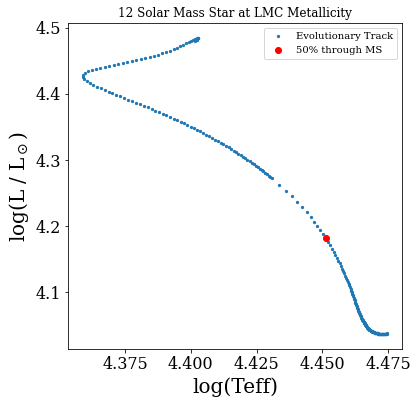

In [45]:
# How to get just the MS
def Get_MS(mist_df):
    # Phase = 0 corresponds to the main sequence
    # From docs: 'Caution: There may be overlap [in phase] between MS and WR for very massive stars. Always double-check!
    # In this case you may want to define "center_h1" going below some threshhold as the end of the MS.'
    # In https://iopscience.iop.org/article/10.3847/0067-0049/222/1/8, they set the beginning of the Terminal age sequence to be when the center_h1 < 1e-12
    # I checked for a 12 solar mass star at LMC metallicity and there's no overlap to worry about, may need to check for other masses and metallicities
    MS_start = np.where(mist_df['phase'] == 0.0)[0][0]
    MS_end = np.where(mist_df['center_h1'] < 1e-12)[0][0]
    MS = mist_df.loc[MS_start:MS_end]
    return MS

# Say that you want to know when the model is X% through the MS
def Get_Percent_Through_MS(MS,percent_through_MS):
    # Phase = 0 corresponds to the main sequence
    min_age = MS['star_age'].min()
    max_age = MS['star_age'].max()
    age_at_percent = percent_through_MS * (max_age - min_age) + min_age
    # Verify you got the correct percent
    percent = np.round(age_at_percent/max_age,2) 
    # If it's not the right percent, print a warning
    diff = np.abs(percent - percent_through_MS)
    if diff > 0.01:
        print(f'The age is {diff} away from the requested percent')
    # Get the row that corresponds to this age 
    age_diff = np.abs(MS['star_age'] - age_at_percent)
    row =  MS.iloc[np.argmin(age_diff)]
    # Verify the ages are close
    how_close = np.abs(row['star_age'] - age_at_percent)/age_at_percent * 100
    # If it's more than, say, 2% off, print a warning
    if how_close > 2:
        print(f'The closest age is {how_close}% away from age')
    return row

# To show this works, first lets plot the evolutionary line on an HRD, and then plot where the star is at 50% through the MS
MS = Get_MS(df)
fifty_percent = Get_Percent_Through_MS(MS,0.5)
# Plot Parameters
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 16 
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['axes.facecolor'] = 'white'

plt.figure(figsize=(6,6)) 
plt.scatter(MS['log_Teff'],MS['log_L'],s=5,label='Evolutionary Track')
plt.scatter(fifty_percent['log_Teff'],fifty_percent['log_L'],color='red',label='50% through MS')
plt.legend()
plt.xlabel('log(Teff)')
plt.ylabel(r'log(L / L$_\odot$)')
plt.title('12 Solar Mass Star at LMC Metallicity')

(3.99, 4.5)

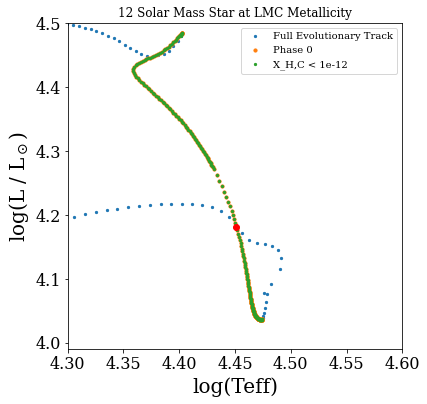

In [43]:
MS2 = df[df['phase'] == 0.0]

# Checking to see if phase 0 has that overlap for a 12 solar mass star at LMC metallicity
plt.figure(figsize=(6,6)) 
plt.scatter(df['log_Teff'],df['log_L'],s=5,label='Full Evolutionary Track')
plt.scatter(MS2['log_Teff'],MS2['log_L'],s=10,label='Phase 0')
plt.scatter(MS['log_Teff'],MS['log_L'],s=5,label='X_H,C < 1e-12')
plt.scatter(fifty_percent['log_Teff'],fifty_percent['log_L'],color='red')
plt.xlabel('log(Teff)')
plt.ylabel(r'log(L / L$_\odot$)')
plt.title('12 Solar Mass Star at LMC Metallicity')
plt.legend()
plt.xlim(4.3,4.6)
plt.ylim(3.99,4.5)